In [1]:
%matplotlib nbagg

# Members
Erik Ström

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 

In [3]:
plt.rcParams['figure.dpi'] = 100

# Function definitions
Here we define our game class that holds our parameters and our particle information, 
as well as update functions and a simple wrap function that wraps the space into something like a torus.

In [4]:
class Game(object):
    def __init__(self, H=100, W=100, N=50, 
                 r1=1, r2=6, r3=11, 
                 rho1=0.3, rho2=0.3, rho3=0.3, rho4=0.1, 
                 alpha=0.85, beta=0.15):
        self.rho1, self.rho2, self.rho3, self.rho4 = rho1, rho2, rho3, rho4
        self.alpha, self.beta = alpha, beta
        self.eta = 3.14

        self.H, self.W = H, W
        self.n_particles = N

        self.r1, self.r2, self.r3 = r1, r2, r3

        self.particles_pos, self.particles_theta = self.init_particles(H, W, N)


    def init_particles(self, H, W, N):
        x = np.random.normal(loc=W/2, scale=W/10, size=(N, 1))
        y = np.random.normal(loc=H/2, scale=H/10, size=(N, 1))
        random_positions = np.concatenate((x, y), axis=1)
        random_theta = np.random.uniform(low=-(np.pi), high=np.pi, size=N)
        return random_positions, random_theta
    
    def wrap(self, i):
        if self.particles_pos[i][0] > self.W:
            self.particles_pos[i][0] -= self.W
        elif self.particles_pos[i][0] < 0:
            self.particles_pos[i][0] += self.W

        if self.particles_pos[i][1] > self.H:
            self.particles_pos[i][1] -= self.H
        elif self.particles_pos[i][1] < 0:
            self.particles_pos[i][1] += + self.H   
    
    # version that handles the 0 neighbour case
    def update_solo_particle(self, e_self):
        rand_angle = np.random.uniform(-self.eta, self.eta)
        e4 = np.array([np.cos(rand_angle), np.sin(rand_angle)])
        return self.alpha*e_self + self.beta*e4
    
    def update_particle(self, e1, e2, e3):
        rand_angle = np.random.uniform(-self.eta, self.eta)
        e4 = np.array([np.cos(rand_angle), np.sin(rand_angle)])
        return self.rho1*e1 + self.rho2*e2 + self.rho3*e3 + self.rho4*e4

    def update_particles(self):
        '''
        Function that updates the particles similarly to
        boids rules'''
        
        num_particles = len(self.particles_pos)
        for i in range(num_particles):
            particle = self.particles_pos[i]      
                                                                               
            avg_x_r3 = 0
            avg_y_r3 = 0
            avg_x_r1 = 0
            avg_y_r1 = 0 
            avg_vector = np.zeros(2)

            n_particles_r1 = 0
            n_particles_r2 = 0
            n_particles_r3 = 0
            
            # iterate over each other particle and calculate the different unit vectors
            for j in range(num_particles):
                if i == j:
                    continue
                    
                neighbour = self.particles_pos[j]
                distance_to_neighbour = np.linalg.norm(particle - neighbour) 

                # We do not have to check all conditions if the previous one is false, 
                # but this impact is probably minimal and 
                # not worth the confusion it could cause reading the code
                if distance_to_neighbour < self.r3:
                    avg_x_r3 += neighbour[0]
                    avg_y_r3 += neighbour[1]
                    n_particles_r3 += 1

                if distance_to_neighbour < self.r2:
                    avg_vector[0] += np.cos(self.particles_theta[j])
                    avg_vector[1] += np.sin(self.particles_theta[j])
                    n_particles_r2 += 1

                if distance_to_neighbour < self.r1:
                    avg_x_r1 += neighbour[0]
                    avg_y_r1 += neighbour[1]
                    n_particles_r1 += 1

            # unit vector representing the direction of the current particle 
            e_i = np.array([np.cos(self.particles_theta[i]), 
                            np.sin(self.particles_theta[i])]) 
            
            # if no particles in the zones we do the other update
            if n_particles_r1 + n_particles_r2 + n_particles_r3 == 0:
                new_vel = self.update_solo_particle(e_self=e_i)
                self.particles_pos[i] += new_vel
                new_vel = new_vel / np.linalg.norm(new_vel)
                self.particles_theta[i] += np.arccos(np.dot(e_i, new_vel))
            else:
                e1 = 0
                if n_particles_r1 > 0:
                    r1_center = np.array([avg_x_r1, avg_y_r1]) / n_particles_r1
                    e1 = particle - r1_center
                    e1_norm = np.linalg.norm(e1)
                    e1 = e1 / e1_norm
                
                e2 = 0
                if n_particles_r2 > 0:
                    e2 = avg_vector / n_particles_r2
                    e2 = e2 / np.linalg.norm(e2)
                
                e3 = 0
                if n_particles_r3 > 0:
                    r3_center = np.array([avg_x_r3, avg_y_r3]) / n_particles_r3
                    e3 = particle + r3_center
                    e3_norm = np.linalg.norm(e3)
                    e3 = e3 / e3_norm

                new_vel = self.update_particle(e1, e2, e3)
                self.particles_pos[i] += new_vel
                # make it a unit vector in case its not
                new_vel = new_vel / np.linalg.norm(new_vel)
                self.particles_theta[i] += np.arccos(np.dot(e_i, new_vel))
            
            # after updating the particles, we make sure
            # they stay within bounds of our field by wrapping, 
            # making the space some sort of torus
            self.wrap(i)

## Test
Plot some updates, first iteration in red, second in blue and third in green.

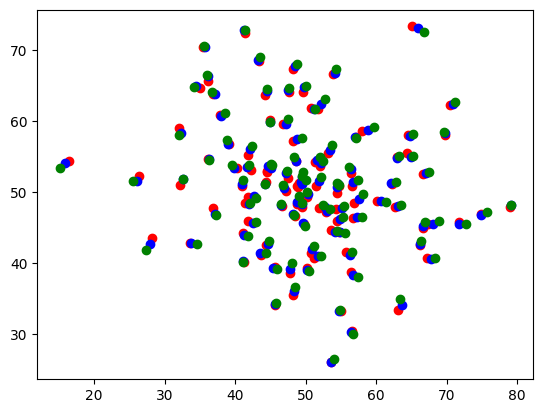

In [5]:
game = Game(H=100, W=100, N=100, r1=3, r2=4, r3=5, rho1=0.25, rho2=0.25, rho3=0.25, rho4=0.25, alpha=0.5, beta=0.5)
plt.plot(game.particles_pos[:,0], game.particles_pos[:,1], 'ro')
game.update_particles()
plt.plot(game.particles_pos[:,0], game.particles_pos[:,1], 'bo')
game.update_particles()
plt.plot(game.particles_pos[:,0], game.particles_pos[:,1], 'go')

## Animate 
Simulate a game for num_simulations and render one simulation each interval=200 ms (or when its done)

To run the animation in this cell you might need to try some different variations of the %matplotlib magic command, though notebook should work

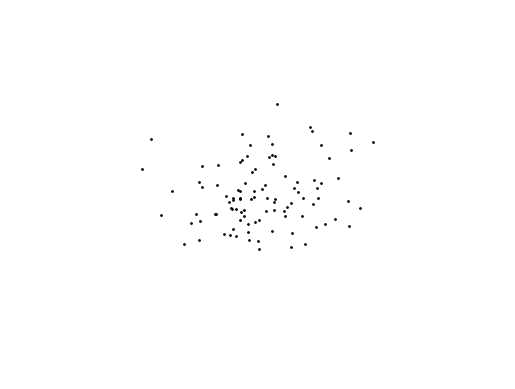

In [6]:
game = Game(H=100, W=100, N=100, 
            r1=3, r2=8, r3=25, 
            rho1=0.3, rho2=0.4, rho3=0.2, rho4=0.1, 
            alpha=0.8, beta=0.2)

num_simulations = 100

fig, ax = plt.subplots()
x, y = game.particles_pos[:,0], game.particles_pos[:,1]
mat, = ax.plot(x, y, 'ko', markersize="1")
plt.xlim([0, game.W])
plt.ylim([0, game.H])
plt.axis('off')

def animate(i):
    global game
    game.update_particles()
    x, y = game.particles_pos[:,0], game.particles_pos[:,1]
    mat.set_data(x, y)

animation = FuncAnimation(fig, animate, frames=num_simulations, interval=200)
plt.show()

# Measure
Since any more advanced measure of clustering requires that we either define some clusters, or possibly that we choose how many particles to count if we were to say only count the $n$ closest neighbours, it is difficult to find a suitable measure that is not clearly biased toward some parameter already. Clearly, if we choose to vary some parameter, say counting the distance to the $n$ closest neighbours, we would also have to measure the difference that parameter makes which seems cumbersome. 

One arguably sensible way of measureing how 'close' members within groups are would be to first construct clusters in such a way that maximizes some clustering measure, e.g. the clustering coefficient, and then measure the average inter-cluster distance for each cluster. This is of course dependant on how good the clustering algorithm is, but at least it would give some indication of the cluster formations. Polarization or average velocity does not necissarily measure how closely together particles are either. 

Because of these difficulties, we settle with simply the average distance between any points in the model. Clearly this is also biased, since we can easily see that some parameters such as $r_1$ or $r_3$ more or less directly affect this measure, and having many well formed clusters far apart is not reflected in this measure.  


In [7]:
def average_distance(particles):
    '''
    Calculates the average distance (L2) between all points
    in the game
    '''
    avg_distance = 0
    N = len(particles)
    # loop over all combinations of 
    # points and add distance to average
    # then divide by number of pairs
    for i in range(N):
        for j in range(i+1, N):
            avg_distance += np.linalg.norm(particles[i] + particles[j])
    return avg_distance / N*(N-1)/2

In [8]:
def run_experiment(game, measure, n_iterations):
    measures = [measure(game.particles_pos)]
    
    for i in range(n_iterations):
        game.update_particles()
    return measure(game.particles_pos)

In [9]:
linspace_rho = np.linspace(0, 1, num=10)
rho1_results = []
rho2_results = []
rho3_results = []
rho4_results = []

for rho in linspace_rho:
    game = Game(rho1=rho)
    rho1_results.append(run_experiment(game, average_distance, 100))
    
    game = Game(rho2=rho)
    rho2_results.append(run_experiment(game, average_distance, 100))
    
    game = Game(rho3=rho)
    rho3_results.append(run_experiment(game, average_distance, 100))
    
    game = Game(rho4=rho)
    rho4_results.append(run_experiment(game, average_distance, 100))

In [10]:
linspace_r = np.linspace(0, 5, num=10)
r1_results = []
r2_results = []
r3_results = []

for r in linspace_r:
    game = Game(r1=r)
    r1_results.append(run_experiment(game, average_distance, 100))
    
    game = Game(r2=r)
    r2_results.append(run_experiment(game, average_distance, 100))
    
    game = Game(r3=r)
    r3_results.append(run_experiment(game, average_distance, 100))

## Plots

### Rho
we first fix $\rho$, and measure how our measure of aggregation varies as $\rho_n$ changes 

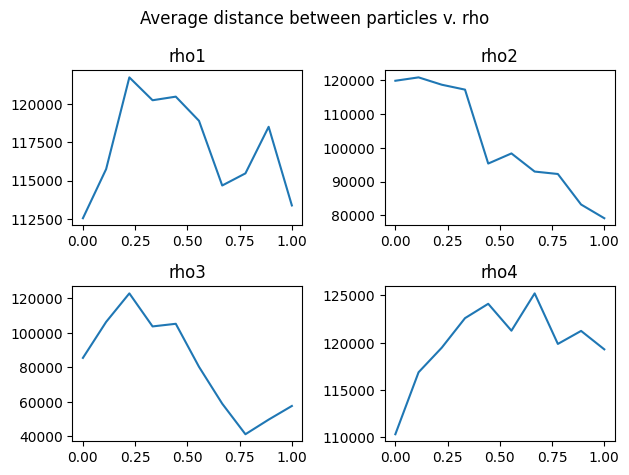

In [20]:
figure, axis = plt.subplots(2, 2)

axis[0, 0].plot(linspace_rho, rho1_results)
axis[0, 0].set_title("rho1")
  
axis[0, 1].plot(linspace_rho, rho2_results)
axis[0, 1].set_title("rho2")
  
axis[1, 0].plot(linspace_rho, rho3_results)
axis[1, 0].set_title("rho3")
  
axis[1, 1].plot(linspace_rho, rho4_results)
axis[1, 1].set_title("rho4")

figure.suptitle("Average distance between particles v. rho")

plt.tight_layout()
plt.show()

### r
We then fix $r$, and see how the measurement changes as the individual $r$ values differ

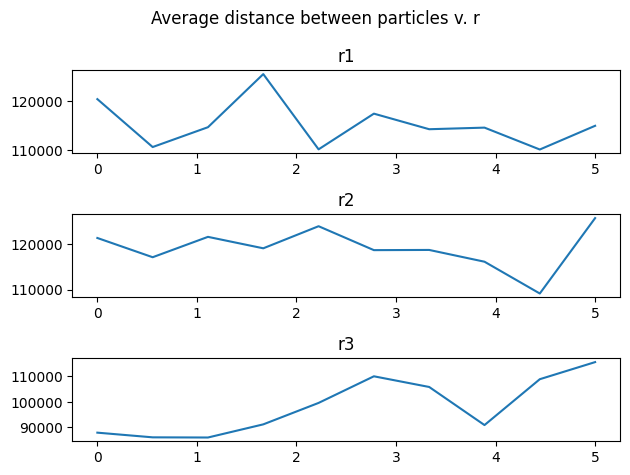

In [18]:
figure, axis = plt.subplots(3)
  
axis[0].plot(linspace_r, r1_results)
axis[0].set_title("r1")

axis[1].plot(linspace_r, r2_results)
axis[1].set_title("r2")

axis[2].plot(linspace_r, r3_results)
axis[2].set_title("r3")

figure.suptitle("Average distance between particles v. r")

plt.tight_layout()
plt.show()

## Results
As we can see, the results are not great and also inherently suffer from variance due to differences in the initialization. To get better results we should vary the other different parameters as well such as number of particles, enclosure size, or test different types of initializations. 

As it stands, the initialization is done by sampling from a random distribution with mean $H/2$ and standard deviation of $H / 10$. As such we should already have some expected average distance. Further, the final measurement is taken after 100 iterations, wheras the results clearly should be shown as varying by time, since the iterations inherently has some randomness in them. Even without the randomness (i.e. setting r4, beta=0) we could see wildly different results based on which iteration we measure at. The measure would most likely be better if we measured it each iteration and then reported the average over the measured timeline.

Despite the results not being very scientific, we can still see that there are some phase transitions in the measure as the different "zones", as it were, approach eachother. 

Similarly, we can see that there appears to be a correlation between the parameters $\rho$ *v*. the average distance, where decreasing $\rho_3$ had the biggest impact as expected, and $\rho_1$ the smallest (other than $\rho_4$) though it does seem to make some difference surprisingly.

Increasing the randomness also seems to increase the average distance between the particles which also is expected since the other parameters in some sense facilitate clustering of particles. 